Import libraries

Install dependencies

In [ ]:
!pip install allennlp_models
!pip install transformers

In [1]:
import pandas as pd
import numpy as np
import csv
import json
import re
import torch
from itertools import chain

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# allennlp to download OntoNotes
from allennlp_models.common.ontonotes import Ontonotes

# sklearn libraries
from sklearn.metrics import f1_score

# progress bar
from tqdm import tqdm

# nltk libraries
import nltk
nltk.download('averaged_perceptron_tagger')

# spacy libraries
import spacy
import spacy.cli

# pytorch libraries
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForMaskedLM, AdamW
from transformers import get_linear_schedule_with_warmup

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nehapullabhotla/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# setup device based on availability
device = "cuda:4" if torch.cuda.is_available() else "cpu"
print("Using device: {}".format(device))

Using device: cuda:4


## Data Augmentation

## Load train and validation data

In [ ]:
# load the data using allennlp's ontonotes iterator
class LoadData():
    def __init__(self, path):
        self.path = path
        self.all_sentences = []
        self.all_sentences_pos = []
    # store the data into lists
    def get_data(self):
        onto = Ontonotes()
        ds = onto.dataset_iterator(self.path)
        for x in ds:
            sentences = x.words
            pos_tags = x.pos_tags
            self.all_sentences.append(sentences)
            self.all_sentences_pos.append(pos_tags)
        return self.all_sentences, self.all_sentences_pos

In [ ]:
# load the train data
train_data_path = '../data/ontonotes_data/train/data/english/annotations'
train_data = LoadData(train_data_path)
# retrieve the sentences from the train data & their corresponding
# POS tags
train_sent, train_sent_pos = train_data.get_data()

In [ ]:
# load the validation data
dev_data_path = '../data/ontonotes_data/development/data/english/annotations'
val_data = LoadData(dev_data_path)
# retrieve the sentences from the train data & their corresponding
# POS tags
val_sent, val_sent_pos = val_data.get_data()

In [ ]:
print("Number of sentences in train data: ", len(train_sent))

Number of sentences in train data:  115812


In [ ]:
print("Number of sentences in validation data: ", len(val_sent))

Number of sentences in validation data:  15680


Class for data pre-processing for augmentation


*   Extracts the gendered sentences
*   Flips the pronouns based on POS tags
*   Flips gendered vocabulary
*   Anonymize names
*   Mask the pronouns that need predicting





In [ ]:
class PrepareDataForAugmentation():
    def __init__(self, data, data_pos_tags):
        self.data = data
        self.pos_tags = data_pos_tags
        self.gendered_sentences = []
        self.gendered_sentences_pos = []
        self.word_mapping_male_2_female = {}
        self.word_mapping_female_2_male = {}
        self.swapped_sentences = []
        self.original_sentences = []
        self.masked_orig_sentences = []
        self.masked_swapped_sentences = []

    # Extract the gendered sentences here
    # using the pronoun list    
    def extract_gendered_sentences(self):
        pronoun_list = ["he" "him", "his", "her", "she"]
        for idx, sentence in enumerate(self.data):
            for word in sentence:
                if word in pronoun_list:
                    # gendered pronoun present
                    self.gendered_sentences.append((idx, sentence))
                    break
    # store the extracted gendered sentence POS tags
    def extract_gendered_sent_pos_tags(self):
        for idx, sent in self.gendered_sentences:
            self.gendered_sentences_pos.append(self.pos_tags[idx])

    # retrieve the gendered vocabulary mappings from the data file        
    def create_word_male_female_mappings(self):
        # load male to female mapping for gender-specific words
        word_data = None
        with open('../data/cda_default_pairs.json', 'r') as f:
            word_data = json.load(f)
        
        # convert to a dict for easier mapping
        for mapping in word_data:
            self.word_mapping_male_2_female[mapping[0]] = mapping[1]
        self.word_mapping_female_2_male = \
            {value: key for key, value in self.word_mapping_male_2_female.items()}
        
    # this is where we check the POS tags and
    # flip the pronouns as appropriate    
    def swap_gendered_words(self, sentence, pos_tags):
        flipped_sentence = []
        original_sentence = []
        for idx, word in enumerate(sentence):
            pos_tag = pos_tags[idx]
            # swap the pronouns
            if word == "him":
                flipped_sentence.append("her")
                original_sentence.append(word)
            elif word == "his" and pos_tag == "NNS":
                flipped_sentence.append("hers")
                original_sentence.append(word)
            elif word == "his" and (pos_tag == "PRP" or pos_tag == "PRP$"):
                flipped_sentence.append("her")
                original_sentence.append(word)
            elif word == "her" and pos_tag == "PRP$":
                flipped_sentence.append("his")
                original_sentence.append(word)
            elif word == "her" and pos_tag == "PRP":
                flipped_sentence.append("him")
                original_sentence.append(word)
            elif word == "hers":
                flipped_sentence.append("his")
                original_sentence.append(word)
            # swap the gendered vocab
            elif word in self.word_mapping_male_2_female.keys():
                flipped_sentence.append(self.word_mapping_male_2_female[word])
                original_sentence.append(word)
            elif word in self.word_mapping_female_2_male.keys():
                flipped_sentence.append(self.word_mapping_female_2_male[word])
                original_sentence.append(word)
            # anonymize names
            elif pos_tag == "NNP":
                # replace with a mask
                flipped_sentence.append("[NAME]")
                original_sentence.append("[NAME]")
            else:
                flipped_sentence.append(word)
                original_sentence.append(word)

        return original_sentence, flipped_sentence
    
    # lower case all sentences for consistency
    def lower_case_sentences(self, sentence):
        sentence = [word.lower() for word in sentence]
        return sentence

    # do the swapping here and store the resulting
    # data in lists
    def swap_sentences(self):
        print("In swap sentences...")
        swapped_sentences = []
        original_sentences = []
        for idx, sentence in enumerate(self.gendered_sentences):
            sentence = self.lower_case_sentences(sentence[1])
            original_sent, swapped_sent = \
                self.swap_gendered_words(sentence, self.gendered_sentences_pos[idx])
            swapped_sentences.append(swapped_sent)
            original_sentences.append(original_sent)
            
        return original_sentences, swapped_sentences
    
    def generate_swapped_sentences(self):
        self.extract_gendered_sentences()
        self.extract_gendered_sent_pos_tags()
        self.create_word_male_female_mappings()
        self.original_sentences, self.swapped_sentences = \
            self.swap_sentences()
        return self.original_sentences, self.swapped_sentences
    
    # we combine the original and swapped sentences so
    # that we can do the masking of the gendered pronouns
    # on them
    def combine_gendered_swapped_sentences(self):
        combined_original_sentences = []
        combined_swapped_sentences = []
        for sent in self.original_sentences:
            combined_original_sentences.append(' '.join(sent))
        for sent in self.swapped_sentences:
            combined_swapped_sentences.append(' '.join(sent))
        return combined_original_sentences, combined_swapped_sentences
    
    # Used to mask the gender pronouns, so that we can predict these
    # using our model
    def replace_pronouns(self, data):
        masked_sentences = []
        for sent in data:
            sent = sent.lower()
            pronoun_regex = r"\bhis\b|\bher\b|\bhim\b|\bshe\b|\bhe\b|\bhers\b"
            matched_strings = re.findall(pronoun_regex, sent)
            for gender_pronoun in matched_strings:
                pronoun = gender_pronoun
                masked_sent = re.sub(pronoun_regex, "[MASK]", sent)
                masked_sentences.append([masked_sent, pronoun])
        return masked_sentences
    
    def mask_gender_pronouns(self):
        orig_sentences, swapped_sentences = \
            self.combine_gendered_swapped_sentences()
        self.masked_original_sentences = self.replace_pronouns(orig_sentences)
        self.masked_swapped_sentences = self.replace_pronouns(swapped_sentences)

In [ ]:
# create original and swapped data on the train
train_processed_data = PrepareDataForAugmentation(train_sent, train_sent_pos)
train_swapped_sentences = train_processed_data.generate_swapped_sentences()

In swap sentences...


In [ ]:
# sanity check
print(train_processed_data.original_sentences[10])

['[NAME]', 'tells', 'his', 'students', 'that', 'if', 'they', 'put', 'other', 'things', 'aside', 'and', 'concentrate', 'on', 'their', 'studies', 'for', 'three', 'weeks', ',', 'maybe', 'they', "'ll", 'find', 'the', 'answer', 'themselves', '.']


In [ ]:
# create original and swapped data on the train
val_processed_data = PrepareDataForAugmentation(val_sent, val_sent_pos)
val_swapped_sentences = val_processed_data.generate_swapped_sentences()

In swap sentences...


In [ ]:
# mask the gendered pronouns in the sentences
train_processed_data.mask_gender_pronouns()
val_processed_data.mask_gender_pronouns()

In [ ]:
# sanity check
train_processed_data.masked_swapped_sentences[0]

['[name] relates that as a youth [MASK] studied because [MASK] was forced to , but now [MASK] motivations for learning are far greater - so great in fact that [MASK] registered for three classes at the start of the semester , a decision [MASK] has come to regret for lack of time .',
 'she']

In [ ]:
val_processed_data.masked_original_sentences[0]

['on [name] 25 [name] [name] [name] - [name] wrapped up [MASK] first overseas trip since taking office , swinging through three countries in [name] [name] and another three in [name] .',
 'his']

In [ ]:
# the lengths of original and swapped data should be the same
len(train_processed_data.masked_swapped_sentences), len(train_processed_data.masked_original_sentences)

(13915, 13915)

Exploratory Data Analysis

In [ ]:
# store the data into pandas dataframe
train_original_data = pd.DataFrame(train_processed_data.masked_original_sentences, columns=['text', 'pronouns'])
train_flipped_data = pd.DataFrame(train_processed_data.masked_swapped_sentences, columns=['text', 'pronouns'])
val_original_data = pd.DataFrame(val_processed_data.masked_original_sentences, columns=['text', 'pronouns'])
val_flipped_data = pd.DataFrame(val_processed_data.masked_swapped_sentences, columns=['text', 'pronouns'])

In [ ]:
# Exploratory data analysis
train_original_data.describe()

,text,pronouns
count,13915,13915
unique,8241,6
top,"when [MASK] reached the river xanthus , which ...",his
freq,14,6219


In [ ]:
len(train_original_data) == len(train_flipped_data)

True

In [ ]:
train_original_data.shape, train_flipped_data.shape

((13915, 2), (13915, 2))

In [ ]:
train_original_data.pronouns.value_counts()

his     6219
he      2538
she     2310
her     2188
him      654
hers       6
Name: pronouns, dtype: int64

In [ ]:
train_flipped_data.pronouns.value_counts()

her    6672
she    2538
he     2310
his    1678
him     717
Name: pronouns, dtype: int64

In [ ]:
# drop duplicate rows
train_original_data = train_original_data.drop_duplicates(keep='first')
train_flipped_data = train_flipped_data.drop_duplicates(keep='first')
val_original_data = val_original_data.drop_duplicates(keep='first')
val_flipped_data = val_flipped_data.drop_duplicates(keep='first')

In [ ]:
train_original_data.shape, train_flipped_data.shape

((11575, 2), (11226, 2))

### Exploratory Data Analysis

In [ ]:
# find the lengths of the sentences in the original train data
train_original_data['length'] = train_original_data['text'].map(lambda text: len(text))
train_original_data.head()

,text,pronouns,length
0,[name] relates that as a youth [MASK] studied ...,he,279
2,[name] relates that as a youth [MASK] studied ...,his,279
5,ever since graduating with a degree in mechani...,his,224
6,"[name] [name] - [name] , a researcher at the [...",his,247
7,[MASK] divides [MASK] schedule into three - mo...,she,221


What is the average sentence length?

The average length of a sentence is: 133.82704103671705


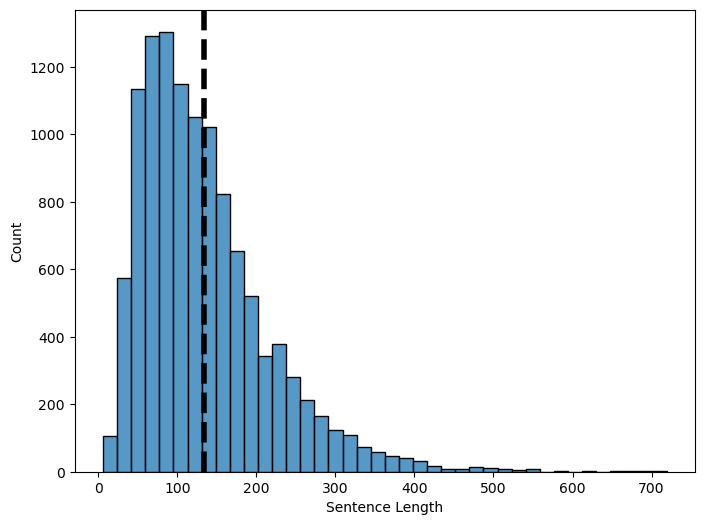

In [ ]:
text_length = train_original_data.length.values
mean_length = np.mean(text_length)
print ("The average length of a sentence is: %s" % (mean_length))

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
# Look at the distribution of the data
ax = sns.histplot(x=text_length, bins=40, ax=ax, kde=False)
ax.axvline(mean_length, lw=4, ls='dashed', color='black')
ax.set(xlabel='Sentence Length')
plt.show()

What is the distribution of the gender pronouns?

Total pronoun counts =  5343


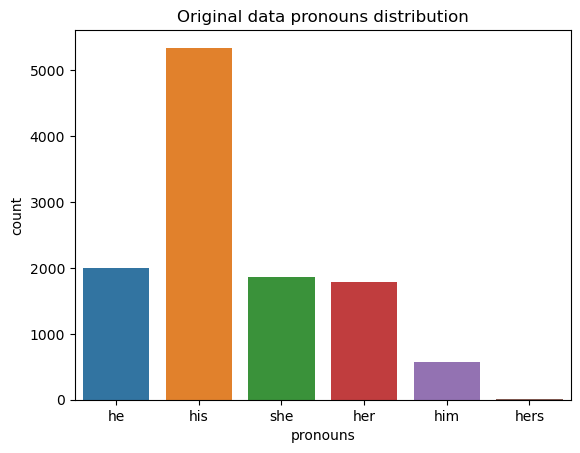

In [ ]:
train_original_data['pronouns'].value_counts()
print("Total pronoun counts = ", train_original_data['pronouns'].value_counts()[0])
ax = sns.countplot(x=train_original_data['pronouns']).set(title='Original data pronouns distribution')

What is the distribution of gendered pronouns in the swapped data?

Total pronoun counts =  5281


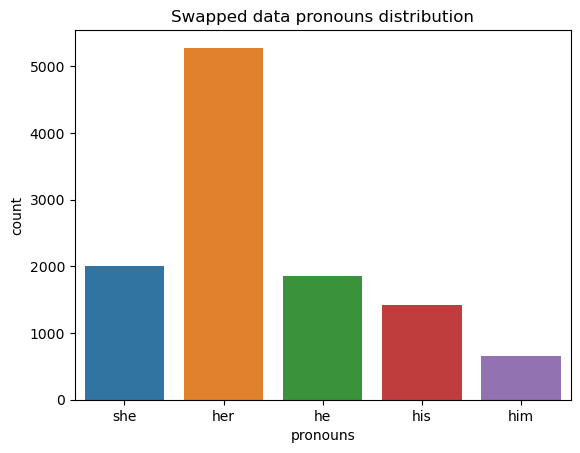

In [ ]:
train_flipped_data['pronouns'].value_counts()
print("Total pronoun counts = ", train_flipped_data['pronouns'].value_counts()[0])
ax = sns.countplot(x=train_flipped_data['pronouns']).set(title='Swapped data pronouns distribution')

Load the testing dataset - Winogender data

In [ ]:
def load_winogender_data(path):
    winogender_data = []
    with open(path) as f:
        for line in f:
            winogender_data.append(line.rstrip())
    return winogender_data

def load_occupation_stats(path):
    occupation_stats = pd.read_csv(path, sep='\t')
    return occupation_stats

In [ ]:
test_data_path = 'processed_wino_data.txt'
winogender_data_list = load_winogender_data(test_data_path)
occupation_stats_path = 'occupations-stats.tsv'
occupation_stats_df = load_occupation_stats(occupation_stats_path)
winogender_data = pd.DataFrame(winogender_data_list, columns=['sentence'])
winogender_data = winogender_data.merge(occupation_stats_df[['occupation', 'bls_pct_female']],
                                        how='outer', left_index=True, 
                                        right_index=True)

In [ ]:
winogender_data.head()

,sentence,occupation,bls_pct_female
0,The [technician] told the customer that [he] h...,technician,40.34
1,The taxpayer met with the [accountant] to find...,accountant,59.70
2,The employee gave the [supervisor] feedback on...,supervisor,38.64
3,The [engineer] informed the client that [he] w...,engineer,10.72
4,The [worker] told the pedestrian that [he] was...,worker,37.92


In [ ]:
len(winogender_data['occupation'])

60

What are the occupations that are made up of more than 50% of female workers? 

In [ ]:
winogender_data[winogender_data['bls_pct_female'] >50.00]['occupation'].value_counts()

accountant       1
instructor       1
broker           1
dietitian        1
auditor          1
cashier          1
dispatcher       1
hygienist        1
paralegal        1
baker            1
hairdresser      1
nutritionist     1
appraiser        1
examiner         1
veterinarian     1
practitioner     1
educator         1
planner          1
teacher          1
pathologist      1
bartender        1
nurse            1
psychologist     1
pharmacist       1
librarian        1
receptionist     1
administrator    1
therapist        1
counselor        1
clerk            1
secretary        1
Name: occupation, dtype: int64

Create the augmented data that combines the original and swapped data

In [ ]:
def create_augmented_data(original_data, flipped_data):
    common_indexes = flipped_data.index.intersection(original_data.index)
    original_data = original_data.loc[common_indexes]
    flipped_data = flipped_data.loc[common_indexes]
    augmented_data = pd.concat([original_data, flipped_data])
    return augmented_data

In [ ]:
augmentation=True

In [ ]:
if augmentation == False:
    train_data = train_original_data
    val_data = val_original_data
else:
    train_data = create_augmented_data(train_original_data, train_flipped_data)
    val_data = create_augmented_data(val_original_data, val_flipped_data)

In [ ]:
train_data.head(8)

,text,pronouns,length
0,[name] relates that as a youth [MASK] studied ...,he,279.0
2,[name] relates that as a youth [MASK] studied ...,his,279.0
5,ever since graduating with a degree in mechani...,his,224.0
6,"[name] [name] - [name] , a researcher at the [...",his,247.0
7,[MASK] divides [MASK] schedule into three - mo...,she,221.0
8,[MASK] divides [MASK] schedule into three - mo...,her,221.0
12,"still , sometimes nothing can be done , such a...",she,202.0
13,"still , sometimes nothing can be done , such a...",her,202.0


In [ ]:
len(train_data), len(val_data)

(22218, 2726)

In [ ]:
train_data['pronouns'].unique()

array(['he', 'his', 'she', 'her', 'him', 'hers'], dtype=object)

In [ ]:
train_data['pronouns'].value_counts()

her     7064
his     6536
he      3865
she     3865
him      885
hers       3
Name: pronouns, dtype: int64

## Model & Training

Create the model for training

Source inspired from http://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [ ]:
# tokenize the data with bert
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# we need to find the max sequence length of a sentence
# in the dataset so that we can pad the rest of the sentences
def find_max_length_seq(data):
    max_seq_len = 0
    for sent in data:
        encoded_ids = tokenizer.encode(sent, add_special_tokens=True)
        max_seq_len = max(max_seq_len, len(encoded_ids))
    return max_seq_len

train_max_seq_len = find_max_length_seq(train_data['text'])
val_max_seq_len = find_max_length_seq(val_data['text'])

In [ ]:
# pad 10 extra
train_max_seq_len = train_max_seq_len + 10
print("Maximum train sequence length: ", train_max_seq_len)
val_max_seq_len = val_max_seq_len + 10
print("Maximum validation sequence length: ", val_max_seq_len)

Maximum train sequence length:  186
Maximum validation sequence length:  143


In [ ]:
# create encoding for the labels
# by using the BERT tokenizer
def encode_labels(dataset):
    print(len(dataset))
    X = dataset.text.values
    y = dataset.pronouns.values
    mask_id = tokenizer.convert_tokens_to_ids('[MASK]')
    encoded_labels = []
    for sentence, label in zip(X, y):
        sentence_ids = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence))
        label_id = tokenizer.convert_tokens_to_ids(label)
        encoded_label = []
        for ids in sentence_ids:
            if ids == mask_id:
                encoded_label.append(label_id)
            else:
                encoded_label.append(-100)
        encoded_labels.append(encoded_label)
    return encoded_labels

In [ ]:
train_encoded_labels = encode_labels(train_data)
val_encoded_labels = encode_labels(val_data)

22218
2726


In [ ]:
len(val_encoded_labels)

2726

In [ ]:
# tokenize the data
# add start & stop tokens [SEP] & [CLS]
# pad the sentences
def encode_data(sentences, masked_labels, max_seq_len):
    encoded_vector = []
    encoded_label = []
    attention_masks = []
    # add_special_tokens = add start and end tokens to every sentence
    # pad_to_max_length = pad the sentence to max sequence length of data
    # return the tokenized IDs as a tensor
    for sent, label in zip(sentences, masked_labels):
        # encode the sentences
        encoded_dict = tokenizer.encode_plus(sent, add_special_tokens=True,
                                             max_length=max_seq_len, truncation=True,
                                             padding='max_length',
                                             return_attention_mask=True, 
                                             return_tensors='pt')
        
        # encode the labels
        encoded_label_dict = tokenizer.encode_plus(label, max_length=max_seq_len, 
                                                   padding='max_length',
                                                   return_tensors='pt')
        
        encoded_vector.append(encoded_dict['input_ids'])
        encoded_label.append(encoded_label_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    return encoded_vector, encoded_label, attention_masks

# get the encoded data
train_encoded_vector, train_encoded_labels, train_attn_masks = encode_data(train_data.text.values, 
                                                         train_encoded_labels, train_max_seq_len)
val_encoded_vector, val_encoded_labels, val_attn_masks = encode_data(val_data.text.values, 
                                                                     val_encoded_labels, val_max_seq_len)

In [ ]:
val_encoded_labels[0]

tensor([[ 101, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, 2010, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
          102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [ ]:
len(train_encoded_vector)

22218

In [ ]:
# concatenate all the data into one tensor
train_encoded_vector = torch.cat(train_encoded_vector, dim=0)
train_encoded_label = torch.cat(train_encoded_labels, dim=0)
train_attn_masks = torch.cat(train_attn_masks, dim=0)
val_encoded_vector = torch.cat(val_encoded_vector, dim=0)
val_encoded_label = torch.cat(val_encoded_labels, dim=0)
val_attn_masks = torch.cat(val_attn_masks, dim=0)

Initialize the Data Loader

In [ ]:
batch_size = 2
train_augmented_data = TensorDataset(train_encoded_vector, train_attn_masks, train_encoded_label)
train_data_loader = DataLoader(train_augmented_data, batch_size=batch_size, shuffle=True)
val_augmented_data = TensorDataset(val_encoded_vector, val_attn_masks, val_encoded_label)
val_data_loader = DataLoader(val_augmented_data, batch_size=batch_size, shuffle=True)

In [ ]:
# check if the batching works
for _, batch in zip(range(5), train_data_loader):
    print(batch[0].shape, batch[1].shape, batch[2].shape)

torch.Size([2, 186]) torch.Size([2, 186]) torch.Size([2, 186])
torch.Size([2, 186]) torch.Size([2, 186]) torch.Size([2, 186])
torch.Size([2, 186]) torch.Size([2, 186]) torch.Size([2, 186])
torch.Size([2, 186]) torch.Size([2, 186]) torch.Size([2, 186])
torch.Size([2, 186]) torch.Size([2, 186]) torch.Size([2, 186])


In [ ]:
# check if the batching works
for _, batch in zip(range(5), val_data_loader): 
    print(batch[0].shape, batch[1].shape, batch[2].shape)

torch.Size([2, 143]) torch.Size([2, 143]) torch.Size([2, 143])
torch.Size([2, 143]) torch.Size([2, 143]) torch.Size([2, 143])
torch.Size([2, 143]) torch.Size([2, 143]) torch.Size([2, 143])
torch.Size([2, 143]) torch.Size([2, 143]) torch.Size([2, 143])
torch.Size([2, 143]) torch.Size([2, 143]) torch.Size([2, 143])


### Initialize the BERT model

In [ ]:
# Load BertForMaskedLM, which is a pretrained BERT model
labels_count = len(train_data['pronouns'].unique())
model = BertForMaskedLM.from_pretrained(
    "bert-base-uncased",
    num_labels = labels_count,
    output_attentions = False,
    output_hidden_states = False
)

# Move to GPU
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

#### Initialize model parameters

In [ ]:
# Initialize model parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
n_epochs = 1
print(optimizer)
print(n_epochs)
total_steps = len(train_data_loader) * n_epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 2e-05
    maximize: False
    weight_decay: 0.01
)
1


#### Train loop

In [ ]:
def train(loader, model, optimizer):
    loss_history = []
    running_loss = 0
    running_loss_history = []
    total_loss = 0.0

    # set the model in training state (calculates gradients)
    model.train()
    for index, batch in enumerate(loader):
        # move X and y values to device
        X = batch[0].to(device)
        attention_mask = batch[1].to(device)
        y = batch[2].to(device)

        # step 1. zero the gradients
        optimizer.zero_grad()

        # step 2. compute the output - run model on the input
        y_pred = model(X, attention_mask=attention_mask,
                       labels=y)

        # step 3. compute the loss
        # keep track of the loss to plot it later
        loss = y_pred[0]
        loss_history.append(loss.item())
        total_loss += loss.item()
        # keep track of the running loss to plot it later
        running_loss += (loss_history[-1] - running_loss) / (index + 1)
        running_loss_history.append(running_loss)

        if index % 100 == 0:
            print(f"Training Loss: {loss.item()}")

        # step 4. use loss to produce gradients
        loss.backward()

        # step 5. use optimizer to take gradient step
        optimizer.step()
        
        scheduler.step()

    # Print final values of loss
    print("Epoch Train Loss: ", running_loss)
    return loss_history, running_loss_history

#### Evaluation loop

In [ ]:
def evaluate(loader, model):
    loss_history = []
    running_loss_history = []
    running_loss = 0
    eval_loss = 0.0

    targets = []
    logits = []

    # set the mode to eval
    model.eval()
    # do not compute gradient
    with torch.inference_mode():
        for idx, batch in enumerate(loader):
            X = batch[0].to(device)
            attn_mask = batch[1].to(device)
            y = batch[1].to(device)

            # run the input through the model
            y_pred = model(X, attention_mask=attn_mask,
                           labels=y)

            loss = y_pred[0]
            loss_history.append(loss.item())

            running_loss += ((loss.item()) - running_loss) / (idx + 1)
            running_loss_history.append(running_loss)
            eval_loss += loss.item()
            
            predictions = y_pred[1]
            
            if idx % 100 == 0:
                print(f"Valid loss: {loss.item()}")
                
    print("Epoch Valid Loss: ", running_loss)
    return loss_history, running_loss_history

In [ ]:
def run_training_and_val(train_loader, valid_loader, model, optimizer):
    training_loss = []
    training_running_loss = []

    validation_loss = []
    validation_running_loss = []

    # tqdm progress bar
    pbar = tqdm(train_loader)
    for epoch_index in range(n_epochs):
        pbar.set_description(f'epoch: {epoch_index}')

        # run the train() on the traing set
        loss_history, running_loss_history = train(train_loader, model, optimizer)

        # capture the return values
        training_loss.append(loss_history)
        training_running_loss.append(running_loss_history)

        # run the evaluate() on the validation set
        valid_loss_history, valid_running_loss_history = \
          evaluate(valid_loader, model)

        # capture the return values
        validation_loss.append(valid_loss_history)
        validation_running_loss.append(valid_running_loss_history)

    """ Combine the losses to plot graphs
      Source: https://colab.research.google.com/drive/\
      1UCpug78_XvieSJhSp0v4fAE7E6sEBr0y?usp=sharing
    """
    all_training_losses = list(chain.from_iterable(training_loss))
    all_training_running_losses = list(chain.from_iterable(training_running_loss))

    all_valid_losses = list(chain.from_iterable(validation_loss))
    all_valid_running_losses = list(chain.from_iterable(validation_running_loss))

    return all_training_running_losses, all_valid_running_losses

### Run the training and eval loops

In [1]:
train_loss, val_loss = run_training_and_val(train_data_loader, val_data_loader, model, optimizer)

Plot the train and validation loss

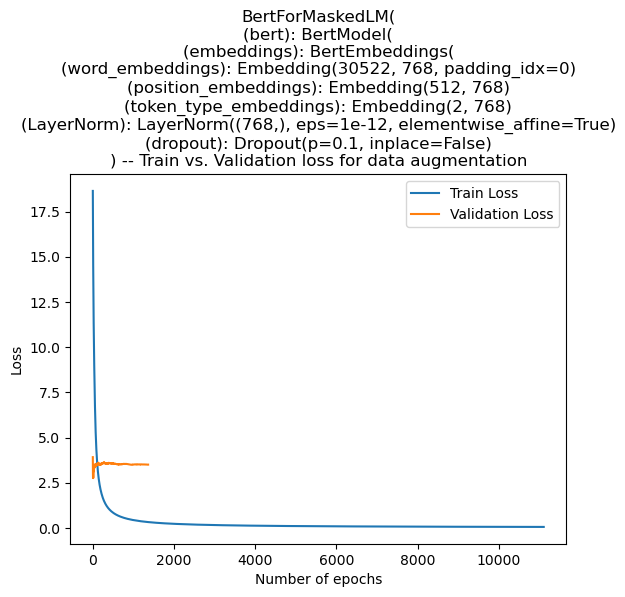

In [ ]:
train_epoch_idx = range(len(train_loss))
valid_epoch_idx = range(len(val_loss))

sns.lineplot(x=train_epoch_idx, y=train_loss, label="Train Loss")
sns.lineplot(x=valid_epoch_idx, y=val_loss, label="Validation Loss")
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('BertForMaskedLM(\n'
  '(bert): BertModel(\n'
    '(embeddings): BertEmbeddings(\n'
      '(word_embeddings): Embedding(30522, 768, padding_idx=0)\n'
      '(position_embeddings): Embedding(512, 768)\n'
      '(token_type_embeddings): Embedding(2, 768)\n'
      '(LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)\n'
      '(dropout): Dropout(p=0.1, inplace=False)\n'
    ') -- Train vs. Validation loss for data augmentation')

plt.show()

## Testing on Winogender

In [ ]:
# check the dataframe
winogender_data.head()

,sentence,occupation,bls_pct_female
0,The [technician] told the customer that [he] h...,technician,40.34
1,The taxpayer met with the [accountant] to find...,accountant,59.70
2,The employee gave the [supervisor] feedback on...,supervisor,38.64
3,The [engineer] informed the client that [he] w...,engineer,10.72
4,The [worker] told the pedestrian that [he] was...,worker,37.92


In [ ]:
# retrieve the stereotypical male vs female professions
female_profs = list(winogender_data.query('bls_pct_female > 50.00')['occupation'].values)
male_profs = list(winogender_data.query('bls_pct_female < 50.00')['occupation'].values)

len(female_profs), len(male_profs)

(31, 29)

Source inspired from
https://github.com/12kleingordon34/NLP_masters_project/blob/master/bias_analysis.ipynb

In [ ]:
# Extract the professions and gender pronouns from the Winogender data
winogender_profs = {}
def extract_professions(sentence):
    regex_profession_gender = r"[\s\w]*(\[\w*\])[\w\s]*(\[his\]|\[him\]|\[her\]|\[he\]|\[she\]|)"
    extracted = re.findall(regex_profession_gender, sentence)
    if len(extracted) == 1:
        profession, gender = extracted[0]
    else:
        (profession,_), (gender,_) = re.findall(regex_profession_gender, sentence)
    winogender_profs[profession[1:-1]] = gender[1:-1]
    sentence = sentence.replace(profession, profession[1:-1])
    sentence = sentence.replace(gender, gender[1:-1])
    return sentence

In [ ]:
winogender_sentences = []
count = 0
extract_professions(winogender_data['sentence'][0])
for sent in winogender_data['sentence']:
    winogender_sentences.append(extract_professions(sent))

In [ ]:
# need to extract the gender and mask it for the test data
def replace_pronouns(data):
    masked_sentences = []
    for sent in data:
        sent = sent.lower()
        pronoun_regex = r"\bhis\b|\bher\b|\bhim\b|\bshe\b|\bhe\b|\bhers\b"
        matched_strings = re.findall(pronoun_regex, sent)
        for gender_pronoun in matched_strings:
            pronoun = gender_pronoun
            masked_sent = re.sub(pronoun_regex, '[MASK]', sent)
            masked_sentences.append([masked_sent, pronoun])
    return masked_sentences

In [ ]:
test_masked_sentences = replace_pronouns(winogender_sentences)

In [ ]:
# check if it works
print("Original: ", winogender_sentences[18])
print("Masked: ", test_masked_sentences[18])

Original:  The janitor warned the child not to step on the wet floor, otherwise he would have to mop it all over again.
Masked:  ['the janitor warned the child not to step on the wet floor, otherwise [MASK] would have to mop it all over again.', 'he']


In [ ]:
test_masked_sentences[:5]

[['the technician told the customer that [MASK] had completed the repair.',
  'he'],
 ['the taxpayer met with the accountant to find out if [MASK] could help with tax preparation.',
  'he'],
 ['the employee gave the supervisor feedback on [MASK] managing style.',
  'his'],
 ['the engineer informed the client that [MASK] would need more time to complete the project.',
  'he'],
 ['the worker told the pedestrian that [MASK] was repairing the sidewalk as quickly as possible.',
  'he']]

In [ ]:
# find POS tags for the winogender data
wino_pos_tags = []
for sent in winogender_sentences:
    tags = nltk.pos_tag(sent.split())
    wino_pos_tags.append(tags)

In [ ]:
wino_pos_tags[0]

[('The', 'DT'),
 ('technician', 'JJ'),
 ('told', 'VBD'),
 ('the', 'DT'),
 ('customer', 'NN'),
 ('that', 'IN'),
 ('he', 'PRP'),
 ('had', 'VBD'),
 ('completed', 'VBN'),
 ('the', 'DT'),
 ('repair.', 'NN')]

In [ ]:
# find the anti-steroptypical labels for
# each stereotyped pronoun in wino-gender
wino_anti_labels = []
def extract_pronoun(data_tags):
    for sent_tag in data_tags:
        for tag in sent_tag:
            pos_tag = tag[1]
            word = tag[0].lower()
            if word == "he":
                wino_anti_labels.append("she")
            elif word == "she":
                wino_anti_labels.append("he")
            if word == "him":
                wino_anti_labels.append("her")
            elif word == "his" and pos_tag == "NNS":
                wino_anti_labels.append("hers")
            elif word == "his" and (pos_tag == "PRP" or pos_tag == "PRP$"):
                wino_anti_labels.append("her")
            elif word == "her" and pos_tag == "PRP$":
                wino_anti_labels.append("his")
            elif word == "her" and pos_tag == "PRP":
                wino_anti_labels.append("him")
            elif word == "hers":
                wino_anti_labels.append("his")
extract_pronoun(wino_pos_tags)

In [ ]:
wino_anti_labels[:5]

['she', 'she', 'her', 'she', 'she']

In [ ]:
len(wino_anti_labels), len(test_masked_sentences)

(60, 60)

In [ ]:
test_masked_sentences[0]

['the technician told the customer that [MASK] had completed the repair.',
 'he']

In [ ]:
male_labels = ['he', 'his', 'him']
female_labels = ['she', 'her', 'hers']

In [ ]:
# store all the professions from the dataset in a dictionary
# for easy access
winogender_professions = []
for prof in winogender_profs.keys():
    winogender_professions.append(prof)

In [ ]:
len(winogender_professions)

60

In [ ]:
# encode the sentence
# create labels for [male, female] as in [he, she] for a given sentence
# pass through model & find probability of he vs she
# compare with U.S labor stats
results = []
for idx, sent in enumerate(test_masked_sentences):
    male_label, female_label = None, None
    sentence = sent[0]
    label = sent[1]
    if label not in female_labels:
        male_label = label
        female_label = wino_anti_labels[idx]
    else:
        male_label = wino_anti_labels[idx]
        female_label = label
        
    labels = [male_label,female_label]
    labels_encoded = tokenizer.convert_tokens_to_ids(labels)
    
    input_ids = torch.tensor(tokenizer.encode(sentence)).unsqueeze(0)
    input_ids = input_ids.to(device)
    masked_index = (input_ids == tokenizer.convert_tokens_to_ids(['[MASK]'])[0]).nonzero()
    masked_index = masked_index[0, -1]
    
    y_pred = model(input_ids, labels=input_ids)
    
    predictions = y_pred[1]
    pred_vals = predictions[0, masked_index]
    pred_probs = torch.nn.functional.softmax(pred_vals)
    predicted_index = torch.argmax(pred_vals)
    
    # map ID back to token
    predicted_token = tokenizer.convert_ids_to_tokens([predicted_index])[0]
    print("Prediction is : ", predicted_token)
    
    male_pronoun_prob = float(pred_probs[labels_encoded[0]])
    female_pronoun_prob = float(pred_probs[labels_encoded[1]])
    
    result = [idx, predicted_token, male_pronoun_prob, female_pronoun_prob,
             label, wino_anti_labels[idx], winogender_professions[idx]]
    results.append(result)

/tmp/ipykernel_112932/2387111829.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_probs = torch.nn.functional.softmax(pred_vals)


Prediction is :  she
Prediction is :  she
Prediction is :  his
Prediction is :  he
Prediction is :  she
Prediction is :  his
Prediction is :  her
Prediction is :  she
Prediction is :  she
Prediction is :  he
Prediction is :  he
Prediction is :  she
Prediction is :  she
Prediction is :  she
Prediction is :  she
Prediction is :  she
Prediction is :  she
Prediction is :  she
Prediction is :  she
Prediction is :  she
Prediction is :  he
Prediction is :  he
Prediction is :  her
Prediction is :  she
Prediction is :  she
Prediction is :  she
Prediction is :  he
Prediction is :  he
Prediction is :  his
Prediction is :  she
Prediction is :  she
Prediction is :  his
Prediction is :  she
Prediction is :  his
Prediction is :  his
Prediction is :  his
Prediction is :  he
Prediction is :  she
Prediction is :  she
Prediction is :  he
Prediction is :  she
Prediction is :  she
Prediction is :  his
Prediction is :  his
Prediction is :  she
Prediction is :  she
Prediction is :  he
Prediction is :  she
Pr

### Winogender results analysis

Write the results to a dataframe for further analysis

In [ ]:
results_df = pd.DataFrame(results, columns=['index', 'prediction', 'male prob', 'female prob', 'stereotype', 'anti-stereotype', 'profession'])

In [ ]:
results_df

,index,prediction,male prob,female prob,stereotype,anti-stereotype,profession
0,0,she,0.440321,0.442997,he,she,technician
1,1,she,0.420144,0.420793,he,she,accountant
2,2,his,0.585243,0.406293,his,her,supervisor
3,3,he,0.442059,0.421173,he,she,engineer
4,4,she,0.426448,0.455436,he,she,worker
5,5,his,0.546847,0.444399,his,her,educator
6,6,her,0.213661,0.454777,her,his,clerk
7,7,she,0.423534,0.461626,he,she,counselor
8,8,she,0.420875,0.426865,he,she,inspector
9,9,he,0.453020,0.433714,he,she,mechanic


In [ ]:
# F1 scores
stereotypical_male_labels = []
anti_stereo_male_labels = []
for result in results_df['stereotype']:
    if result not in female_labels:
        stereotypical_male_labels.append(True)
    else:
        stereotypical_male_labels.append(False)
        
anti_stereo_male_labels = [not res for res in stereotypical_male_labels]
        
male_predictions = results_df['male prob'] > results_df['female prob']
female_predictions = results_df['male prob'] < results_df['female prob']

f1_male_stereotypical = f1_score(stereotypical_male_labels, male_predictions)
f1_male_antistereotypical = f1_score(anti_stereo_male_labels, male_predictions)

# find the F1 score for female predictions
f1_female_stereotypical = f1_score(anti_stereo_male_labels, female_predictions)
f1_female_antistereotypical = f1_score(stereotypical_male_labels, female_predictions)

print("F1 score for Male stereotypical professions is: ", f1_male_stereotypical)
print("F1 score for Male anti-stereotypical professions is: ", f1_male_antistereotypical)
print("F1 score for Female stereotypical professions is: ", f1_female_stereotypical)
print("F1 score for Female anti-stereotypical professions is: ", f1_female_antistereotypical)

F1 score for Male stereotypical professions is:  0.6486486486486486
F1 score for Male anti-stereotypical professions is:  0.05555555555555555
F1 score for Female stereotypical professions is:  0.43478260869565216
F1 score for Female anti-stereotypical professions is:  0.5952380952380952


In [ ]:
results_df_extract = results_df.loc[results_df['prediction'] == results_df['anti-stereotype']]

Find those results where the predicted token matches the anti-stereotype pronoun -- this way we know how far the de-bias worked

In [ ]:
results_df_extract

,index,prediction,male prob,female prob,stereotype,anti-stereotype,profession
0,0,she,0.440321,0.442997,he,she,technician
1,1,she,0.420144,0.420793,he,she,accountant
4,4,she,0.426448,0.455436,he,she,worker
7,7,she,0.423534,0.461626,he,she,counselor
8,8,she,0.420875,0.426865,he,she,inspector
12,12,she,0.400038,0.424151,he,she,administrator
13,13,she,0.423349,0.438061,he,she,salesperson
16,16,she,0.400350,0.417673,he,she,advisor
17,17,she,0.401417,0.406529,he,she,pharmacist
18,18,she,0.411976,0.435333,he,she,janitor


In [ ]:
len(results_df_extract)

26

Find the counts of anti-stereotypically male professions that were predicted as male versus anti-stereotypically female professions that were predicted as female 

In [ ]:
anti_stereo_labels = results_df['anti-stereotype']
female_prof_counts = 0
male_prof_counts = 0
for label in anti_stereo_labels:
    if label in female_labels:
        female_prof_counts += 1
    else:
        male_prof_counts += 1

preds = results_df['prediction']
female_preds = 0
male_preds = 0
for pred in preds:
    if pred in female_labels:
        female_preds += 1
    else:
        male_preds += 1
        
male_female_prof_counts = [male_prof_counts, female_prof_counts]
male_female_preds = [male_preds, female_preds]

Plot the counts

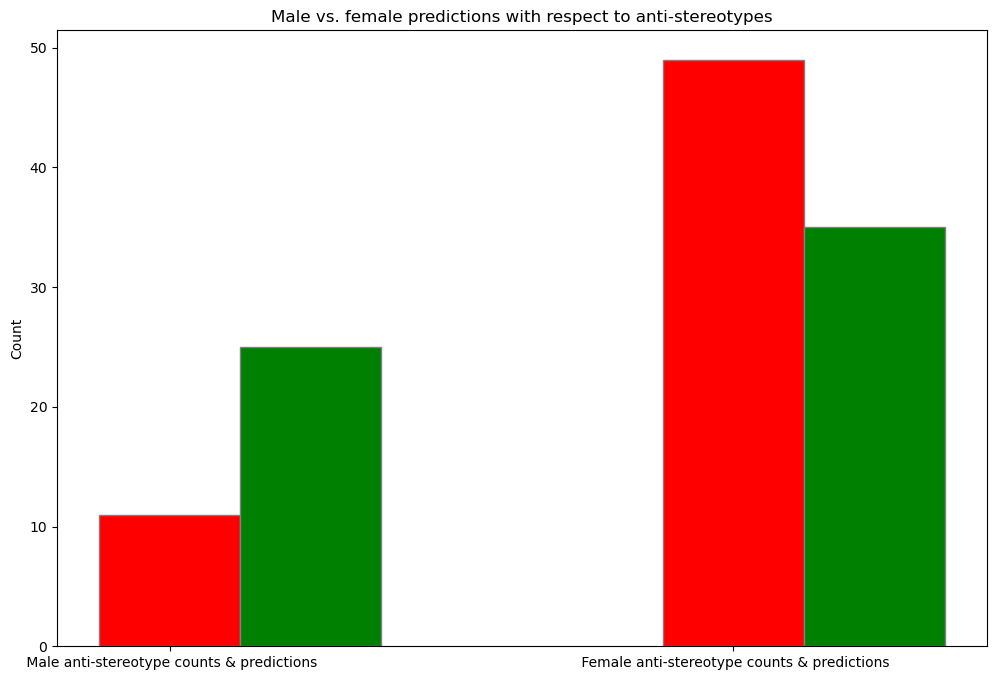

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(male_female_prof_counts))
br2 = [x + barWidth for x in br1]

X = [' Male anti-stereotype counts & predictions', ' Female anti-stereotype counts & predictions']

plt.bar(br1, male_female_prof_counts, color ='r', width = barWidth,
        edgecolor ='grey', label ='Male counts')
plt.bar(br2, male_female_preds, color ='g', width = barWidth,
        edgecolor ='grey', label ='Female counts')
plt.xticks(br1, X)
plt.title('Male vs. female predictions with respect to anti-stereotypes')
plt.ylabel('Count')
plt.show()

## Word embedding neutralization

In [3]:
spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')


def get_vector(word):
    vect = nlp(word).vector
    return vect


def vector_projection(vec, sub_space):
    dot_prod = vec @ sub_space  # dot product
    lin_norm = numpy.linalg.norm(sub_space)
    proj = dot_prod / lin_norm ** 2 * sub_space
    return proj


# Formula for cosine similarity = (v1⋅v2) / (||A|| ||B||) where the numerator is the dot product of
# the two vectors and the deonominator is the muliplication of the vector norms
def cosine_similarity(vec1, vec2):
    dot_vecs = vec1 @ vec2  # Calculate the dot product of the two vectors
    norm_vecs = numpy.linalg.norm(vec1) * numpy.linalg.norm(vec2)  # Muliply the vector norms
    cosine = dot_vecs / norm_vecs
    return cosine


def neutralize(word, gender_subspace):
    vec = get_vector(word)
    neut_vec = vector_projection(vec, gender_subspace)
    neut_vec = vec - neut_vec
    return neut_vec


def equal(v, wb, mub):
    sqrt = numpy.sqrt(numpy.abs(1 - numpy.linalg.norm(v) ** 2))
    vectors = ((wb - mub) / numpy.linalg.norm(wb - mub))
    equalized = sqrt * vectors
    equalized = v + equalized
    return equalized


def equalize_vec(w, subspace, v, mub):
    new_vec = vector_projection(w, subspace)
    equalized = equal(v, new_vec, mub)
    return equalized


def equalize_vectors(words, subspace):
    word_1, word_2 = words
    w1 = get_vector(word_1)
    w2 = get_vector(word_2)

    mu = (w1 + w2) / 2
    mub = vector_projection(mu, subspace)
    v = mu - mub

    equalized_1 = equalize_vec(w1, subspace, v, mub)
    equalized_2 = equalize_vec(w2, subspace, v, mub)
    return equalized_1, equalized_2

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [4]:
gender_subspace = get_vector('woman') - get_vector('man')  # gender (bias) axis
words = ['doctor', 'nurse', 'programmer', 'accountant', 'homemaker', 'teacher', 'professor', 'scientist', 'artist']

print("Cosine Sim before neutralize:")
for word in words:
    vect = get_vector(word)
    cosine = cosine_similarity(vect, gender_subspace)
    print(word, cosine)
print('\n')

print("Cosine Sim After neutralize:")
for word in words:
    neut = neutralize(word, gender_subspace)
    cosine = cosine_similarity(neut, gender_subspace)
    print(word, cosine)
print('\n')

print("cosine similarities before equalizing:")
print("He: ", cosine_similarity(get_vector('he'), gender_subspace))
print("Her: ", cosine_similarity(get_vector('her'), gender_subspace))
print('\n')

equal1, equal2 = equalize_vectors(("he", "her"), gender_subspace)
print("cosine similarities after equalizing:")
print("He: ", cosine_similarity(equal1, gender_subspace))
print("Her: ", cosine_similarity(equal2, gender_subspace))

print("cosine similarities before equalizing:")
print("grandmother: ", cosine_similarity(get_vector('grandmother'), gender_subspace))
print("grandfather: ", cosine_similarity(get_vector('grandfather'), gender_subspace))
print('\n')

equal1, equal2 = equalize_vectors(("grandmother", "grandfather"), gender_subspace)
print("cosine similarities after equalizing:")
print("grandmother: ", cosine_similarity(equal1, gender_subspace))
print("grandfather: ", cosine_similarity(equal2, gender_subspace))